# Morphology

In [580]:
# imports
import skimage as ski
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np
from im_func import show_image
import seaborn as sns
from skimage import transform
from time import time
import contextlib

@contextlib.contextmanager
def timer(msg):
    tic = time()
    yield
    print(msg + ": %.2f s" % (time() - tic))

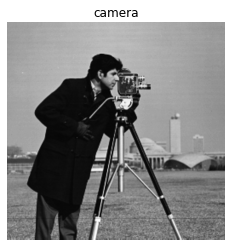

In [674]:
# Load stock image using function
title = 'camera'
# title = 'coffee'
# title = 'checkerboard'
image = getattr(ski.data, title)()

show_image(image, title)

# Binarize the picture

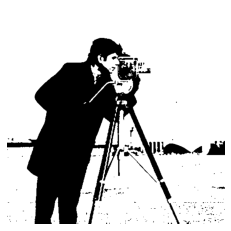

In [675]:
if image.ndim==3:
    image_gray = ski.color.rgb2gray(image)
elif image.ndim==3 and np.max(image)>1.0: 
    image_gray = image/255.0
else:
    image_gray = image
thr = ski.filters.threshold_otsu(image_gray)
image_bin = image_gray>thr
show_image(image_bin)

# Morphological operations from scratch

A structuring element, is a small image (i.e. kernel) that is compared with the original image in a convolutional fashion.
There are four morphological operations:
- dilation
- erosion
- closing: connects shapes (dilation, then erosion)
- opening: creates holes between shapes (erosion, then dilation)

## Define a structuring element

In [676]:
def structural_element(shape='square',size=(3,3)):
    if size[0]%2==0 or size[1]%2==0:
        raise ValueError("the size must be contain only odd numbers.")
    if shape=='square':
        return np.ones(size)
    elif shape=='rectangle':
        return np.ones(size)
    elif shape=='cross':
        struct_el = np.zeros(size)
        struct_el[int((size[0]-1)/2),:] = 1
        struct_el[:,int((size[1]-1)/2)] = 1
        return struct_el
    elif shape=='disk':
        x, y  = np.meshgrid(np.arange(size[0])-int((size[0]-1)/2),
                            np.arange(size[1])-int((size[1]-1)/2))
        struct_el = ((x**2 + y**2)<=int((size[0]-1)/2)**2).astype(float)
        return struct_el
    else:
        raise ValueError('Unknown shape.')

# Apply morphology

In [708]:
im = 1-image_bin

def apply_morph(im,struct_element='square',size=(5,5),morph='erosion'):
    struct_el = (structural_element(struct_element,size)).astype(bool)
    ipad = int((size[0]-1)/2)
    jpad = int((size[1]-1)/2)
    if morph == 'erosion':
#         return np.array([[np.all((im[i-ipad:i+ipad+1,j-jpad:j+jpad+1]==1).astype(int) - struct_el.astype(int) >=0)
#                       for j in range(jpad,im.shape[1]-jpad)] 
#                       for i in range(ipad,im.shape[0]-ipad)])
        im_out = np.ones(im.shape)
        for i in range(ipad,im.shape[0]-ipad):
            for j in range(jpad,im.shape[1]-jpad):
                if im[i,j]==0:
                    im_out[i-ipad:i+ipad+1,j-jpad:j+jpad+1] -= struct_el
        im_out[im_out<0] = 0
        
        return im_out
    elif morph == 'dilation':
        im_out = np.zeros(im.shape)
        for i in range(ipad,im.shape[0]-ipad):
            for j in range(jpad,im.shape[1]-jpad):
                if im[i,j]==1:
                    im_out[i-ipad:i+ipad+1,j-jpad:j+jpad+1] += struct_el
        im_out[im_out>1] = 1
        
        return im_out
    elif morph == 'opening':
        return apply_morph(apply_morph(im,struct_element,size,'erosion'),struct_element,size,'dilation')
    elif morph == 'closing':
        return apply_morph(apply_morph(im,struct_element,size,'dilation'),struct_element,size,'erosion')
    elif morph == 'none':
        return im
    else:
        raise ValueError('Unknown morph')
    

@interact
def apply_morphology(size=(0,21,1),shape=['disk','square','cross'],morphology=['none','dilation','erosion','opening','closing','outline'],
                     invert=False):
    if invert:
        im = 1-image_bin
    else:
        im = image_bin
    if morphology=='outline':
        morphology='dilation'
        A = apply_morph(1-image_bin,struct_element=shape,size=(1+2*size,1+2*size),morph=morphology)
        A -= (1-image_bin)
        A[A<0] = 0
        show_image(A)
    else:
        show_image(apply_morph(im,struct_element=shape,size=(1+2*size,1+2*size),morph=morphology)   )
    
    
    
    

interactive(children=(IntSlider(value=10, description='size', max=21), Dropdown(description='shape', options=(…

# Using skimage

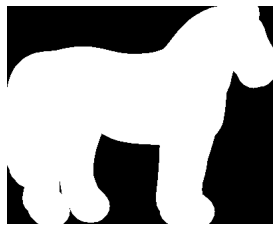

In [632]:
struct_el = ski.morphology.disk(21)
im_out = ski.morphology.dilation(1-image,selem=struct_el)
show_image(im_out)

In [652]:
A = np.arange(10)

array([], dtype=int64)